<a href="https://colab.research.google.com/github/Ddkaba/IAD_Lab_1/blob/main/IAD_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Группа 4232

Спицов А.

Михайлов Д.

Вариант №2 (Набор данных цен на недвижимость)

In [2]:
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [3]:
dataset = pd.read_csv("https://raw.githubusercontent.com/Ddkaba/IAD_Lab_1/main/V2.csv", index_col=0)
if 'No' in dataset.columns:
    dataset = dataset.drop(columns=['No'])

In [4]:
print("Общая информация")
print(dataset.info())

print(f"Количество записей (объектов): {dataset.shape[0]}")
print(f"Количество признаков (фич): {dataset.shape[1]}")

print("\nНазвания столбцов:")
print(dataset.columns.tolist())

print("\nТипы данных:")
print(dataset.dtypes)

print("\nПропущенные значения:")
missing_values = dataset.isnull().sum()
print(missing_values)
print(f"Общее количество пропущенных значений: {missing_values.sum()}")

print("Целевая переменная")
target_column = 'Y house price of unit area'
if target_column in dataset.columns:
    print(f"\nЦелевая переменная: {target_column}")
    print(f"Тип данных целевой переменной: {dataset[target_column].dtype}")
    unique_values = dataset[target_column].unique()
    print(f"Уникальные значения целевой переменной (первые 20): {unique_values[:20]}")
    print(f"Всего уникальных значений: {unique_values.size}")
    if dataset[target_column].nunique() <= 20:
        print("Распределение классов:")
        print(dataset[target_column].value_counts())
        print("Процентное соотношение классов:")
        print(dataset[target_column].value_counts(normalize=True) * 100)

print("Статистика")
print(dataset.describe())

print("Анализ кат. признаков")
categorical_features = []
for col in dataset.columns:
    unique_values = dataset[col].nunique(dropna=True)
    if unique_values <= 10:
        categorical_features.append(col)
        print(f"{col}: {unique_values} уникальных значений - {dataset[col].unique()}")

print(f"\nВсего категориальных признаков: {len(categorical_features)}")

print("Корреляции признаков с целевой переменной:")
corr_matrix = dataset.corr()
if target_column in corr_matrix.columns:
    print(corr_matrix[target_column].sort_values(ascending=False))


Общая информация
<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1 transaction date                     414 non-null    float64
 1   X2 house age                            205 non-null    float64
 2   X3 distance to the nearest MRT station  414 non-null    float64
 3   X4 number of convenience stores         414 non-null    int64  
 4   X5 latitude                             414 non-null    float64
 5   X6 longitude                            414 non-null    float64
 6   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 25.9 KB
None
Количество записей (объектов): 414
Количество признаков (фич): 7

Названия столбцов:
['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 l

Данный датасет — таблица с данными о 414 домах, описанных по 7 признакам.
Главная цель — предсказать цену за единицу площади (столбец Y house price of unit area, тип float64), которая варьируется от 7.6 до 117.5 с медианой 38.45, это говорит о большом разбросе цен. Столбцы включают: дату сделки (transaction date, float64, 2012–2013 годы, среднее 2013.15,
разброс небольшой), возраст дома (house age, float64, среднее 18.2 года, от 0 до 43.8 лет),
расстояние до ближайшей станции метро (distance to the nearest MRT station, float64, среднее 1084 м, от 23 до 6488 м),
количество магазинов поблизости (number of convenience stores, int64, среднее 4, от 0 до 10), широту (latitude, float64, среднее 24.969, диапазон 24.932–25.015) и
долготу (longitude, float64, среднее 121.533, диапазон 121.474–121.566). Пропуски есть только в возрасте дома, остальные столбцы заполнены полностью.
Категориальных признаков нет, все данные числовые.
Пропуски в возрасте дома — главная проблема, их нужно либо заполнить, либо исключить этот признак.
Сильная положительная корреляция с ценой наблюдается для количества магазинов поблизости (0.57), что указывает на то, что больше магазинов вокруг — выше цена,
а также для широты (0.55) и долготы (0.52), намекающих на влияние престижности определённых районов, тогда как дата сделки (0.09) почти не влияет.
Сильная отрицательная корреляция видна с расстоянием до метро (-0.67) — чем дальше до станции, тем ниже цена.
Это значит, что цена на дома больше всего зависит от близости к метро и наличия магазинов — чем ближе метро и больше магазинов, тем дороже жильё,
а географическое положение тоже играет роль, возможно, отражая престижность района, тогда как возраст дома и дата сделки влияют слабо,
что может быть связано с узким периодом данных (2012–2013) и пропусками в house age.

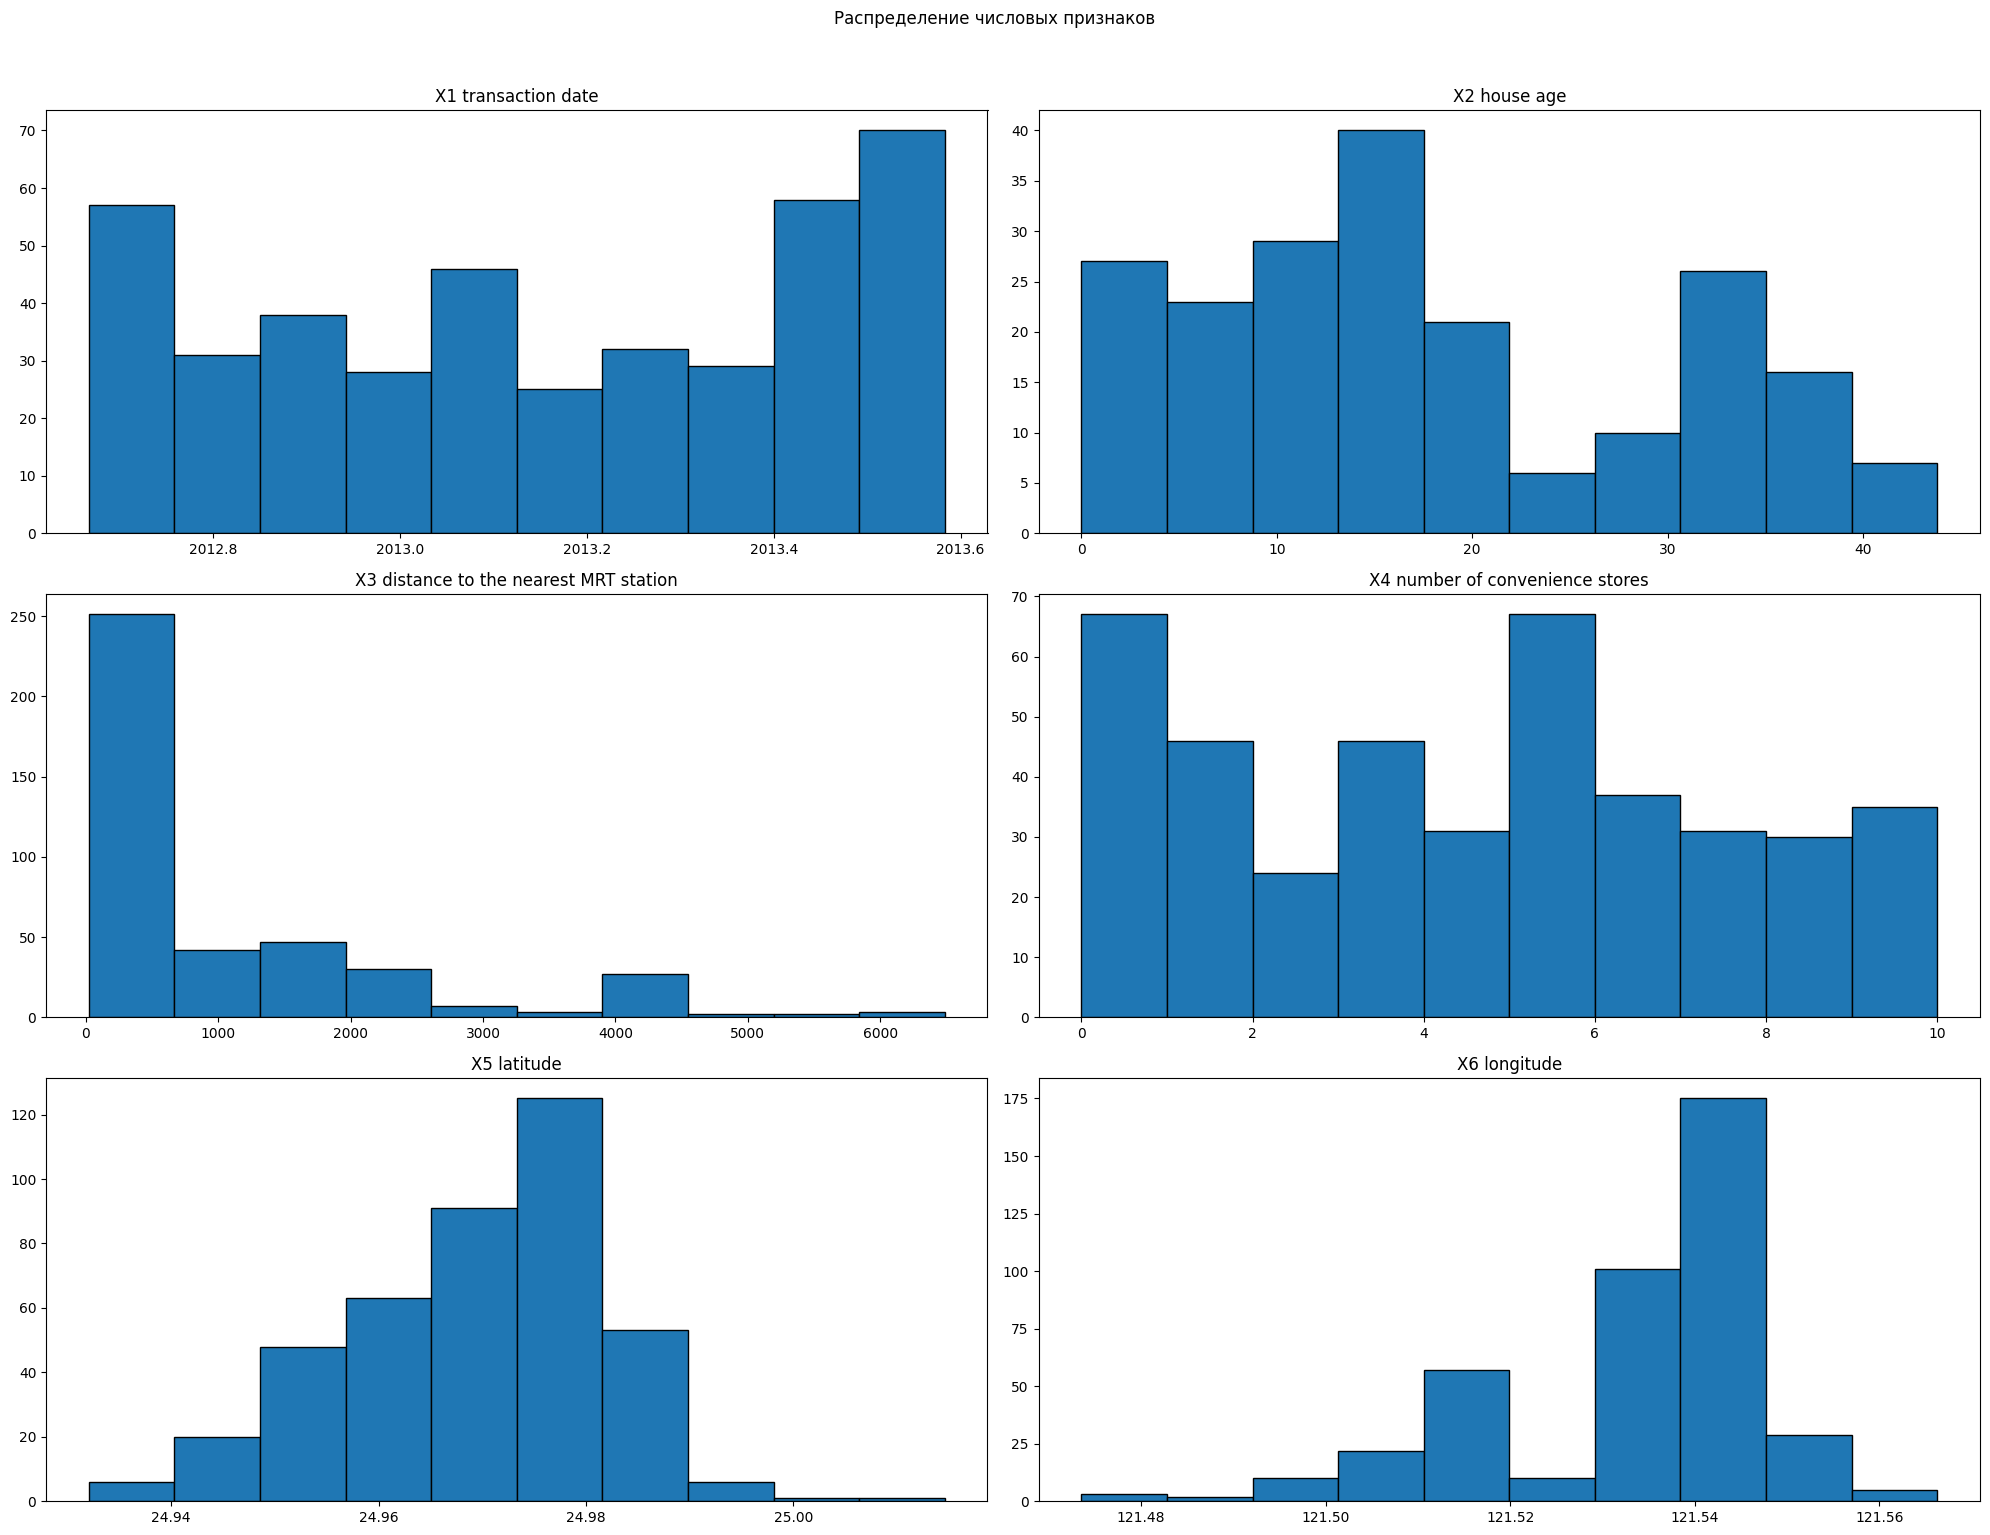

In [5]:
# Гистограммы по всем числовым признакам
# Определим список числовых колонок и исключим целевую, если она есть
feature_columns = dataset.select_dtypes(include=[np.number]).columns.tolist()
if 'Y house price of unit area' in feature_columns:
    feature_columns.remove('Y house price of unit area')

_ = dataset[feature_columns].hist(
    bins=10,
    figsize=(20, 15),
    grid=False,
    edgecolor='black'
)
plt.suptitle('Распределение числовых признаков', y=1.02)
plt.tight_layout()
plt.show()


Для даты сделки (transaction date) распределение охватывает период с октября 2012 года до июля 2013 года, с пиками активности около января 2013 года и апреля 2013 года, где число сделок достигает около 60–70, тогда как в промежутках (май 2013 года) наблюдается спад до 30–40 сделок, что указывает на неравномерность сделок в течение года. Возраст дома (house age) показывает, что большинство домов сосредоточено в диапазоне 0–10 лет (до 40 домов) и 30–40 лет (около 40 домов), с меньшим количеством в промежутке 10–30 лет (около 20–30 домов), что может отражать популярность новых и старых домов, с учётом 50% пропусков в данных. Расстояние до метро (distance to the nearest MRT station) имеет резкий пик до 500 метров (около 250 домов), после чего количество домов резко падает, с единичными объектами на расстоянии 4000–6000 метров, что говорит о преобладании домов близко к метро. Количество магазинов (number of convenience stores) распределено с пиком на 0–2 магазина (до 70 домов) и 6–8 магазинах (около 60 домов), с меньшим числом домов при 4–6 магазинах, отражая неравномерность инфраструктуры. Широта (latitude) сосредоточена в диапазоне 24.96–24.98 (пики около 120 домов), с редкими значениями ниже 24.94 и выше 25.00, указывая на компактную географическую зону. Долгота (longitude) имеет основной диапазон 121.52–121.54 (пики до 175 домов), с меньшим количеством домов на краях (121.48 и 121.56), также подтверждая локализацию данных. В целом, гистограммы показывают, что данные сосредоточены в определённой местности с близким расположением к метро и неравномерным доступом к магазинам, а сделки и возраст домов имеют заметные пики, что может быть связано с рыночными трендами или выборкой.

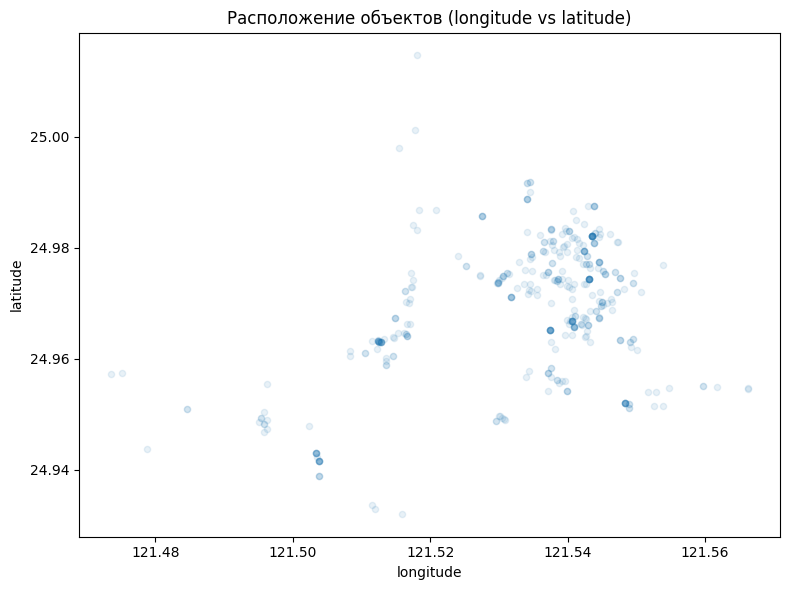

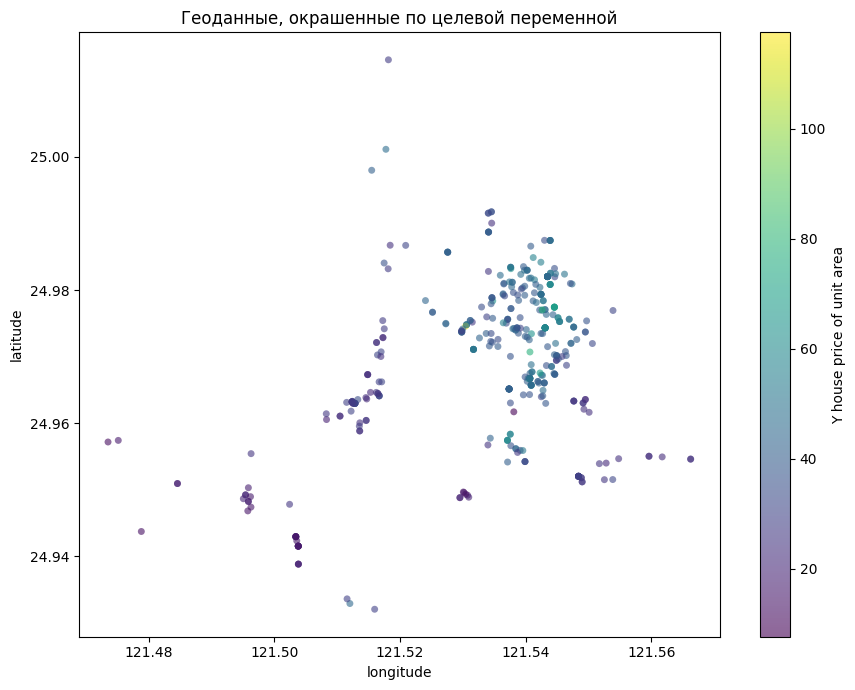

In [6]:
# Геовизуализация: долгота vs широта
lon_col = 'X6 longitude'
lat_col = 'X5 latitude'

# Построение базового scatter-графика для визуализации распределения объектов
ax = dataset.plot(kind='scatter', x=lon_col, y=lat_col, alpha=0.1, figsize=(8, 6))
ax.set_title('Расположение объектов (longitude vs latitude)')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.tight_layout()
plt.show()

# Раскраска по целевой (если есть)
if 'Y house price of unit area' in dataset.columns:
    plt.figure(figsize=(9, 7))
    sc = plt.scatter(
        dataset[lon_col], dataset[lat_col],
        c=dataset['Y house price of unit area'], cmap='viridis',
        s=25, alpha=0.6, edgecolors='none'
    )
    cbar = plt.colorbar(sc)
    cbar.set_label('Y house price of unit area')
    plt.title('Геоданные, окрашенные по целевой переменной')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.tight_layout()
    plt.show()


На основе двух графиков — диаграммы рассеяния координат
и географического распределения домов с цветовой шкалой цен за единицу площади — можно сделать следующие выводы.
Первый график показывает, что дома сосредоточены в довольно компактной зоне,
с плотным скоплением точек, это указывает на то, что данные относятся к ограниченному региону.
Второй график: более высокие цены наблюдаются в центральной части скопления, тогда как более низкие цены встречаются по краям, особенно в зонах с меньшей плотностью домов. Это указывает на то, что цена за единицу площади выше в более густонаселённых или центральных районах, что согласуется с ранее отмеченной сильной отрицательной корреляцией между ценой и расстоянием до метро — центральные зоны ближе к инфраструктуре. Распределение цен также подчёркивает влияние географического положения, где широта и долгота играют важную роль в определении стоимости.
Таким образом, данные подтверждают, что жильё в центре этой зоны дороже, вероятно, благодаря близости к метро и магазинам, а периферийные районы дешевле.

---



**Получение первого набора данных:**

Медиана X2 house age: 16.200
Пропусков до/после: 209 -> 0


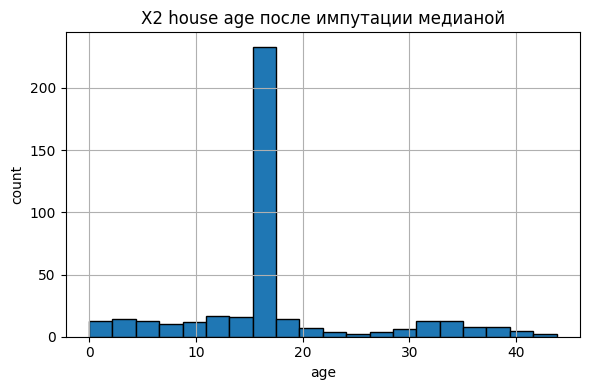


Топ корреляций с целевой переменной:
Y house price of unit area                1.000000
X4 number of convenience stores           0.571005
X5 latitude                               0.546307
X6 longitude                              0.523287
X1 transaction date                       0.087491
X2 house age                             -0.143517
X3 distance to the nearest MRT station   -0.673613
Name: Y house price of unit area, dtype: float64


In [7]:
TARGET = 'Y house price of unit area'

# Импутация пропусков в X2 house age медианой
col = 'X2 house age' # Указание столбца, в котором будут импутироваться пропуски
med = dataset[col].median() # Вычисление медианы для столбца 'X2 house age'
missing_before = dataset[col].isna().sum()

dataset[col] = dataset[col].fillna(med)
missing_after = dataset[col].isna().sum()

#Сохраняем первый набор данных в df_original
df_original = dataset.copy()

# Вывод информации о медиане и количестве пропусков до и после импутации
print(f"Медиана {col}: {med:.3f}")
print(f"Пропусков до/после: {missing_before} -> {missing_after}")

# Визуальная проверка распределения после импутации
plt.figure(figsize=(6, 4))
dataset[col].hist(bins=20, edgecolor='black')
plt.title(f'{col} после импутации медианой')
plt.xlabel('age')
plt.ylabel('count')
plt.tight_layout()
plt.show()

# Проверка корреляции с целевой переменной и вывод топ-корреляций
corr = dataset.corr()
if TARGET in corr.columns:
    print('\nТоп корреляций с целевой переменной:')
    print(corr[TARGET].sort_values(ascending=False).head(15))

Гистограмма показывает распределение возраста домов после импутации пропусков медианой, которая составила 16.2 лет. Изначально было 209 пропусков, и после заполнения их медианой пропусков не осталось. Распределение имеет резкий пик около 16–17 лет, где количество объектов достигает около 200, что соответствует медиане, используемой для заполнения. Другие возрастные группы имеют значительно меньше объектов, что указывает на доминирование домов среднего возраста в датасете после импутации. Топ корреляции отражает взаимосвязи между признаками после этой обработки. Целевая переменная сохраняет сильную
положительную корреляцию с количеством магазинов (0.571), широтой (0.546) и долготой (0.523), а также слабую с датой сделки (0.087). Отрицательная корреляция с расстоянием до метро (-0.674) остаётся значительной.


---



**Получение второго набора данных:**


Оценки информативности (f_regression), по убыванию:
                                  feature       score
0  X3 distance to the nearest MRT station  342.239318
1         X4 number of convenience stores  199.318238
2                             X5 latitude  175.271845
3                            X6 longitude  155.359301
4                            X2 house age    8.664463
5                     X1 transaction date    3.178024


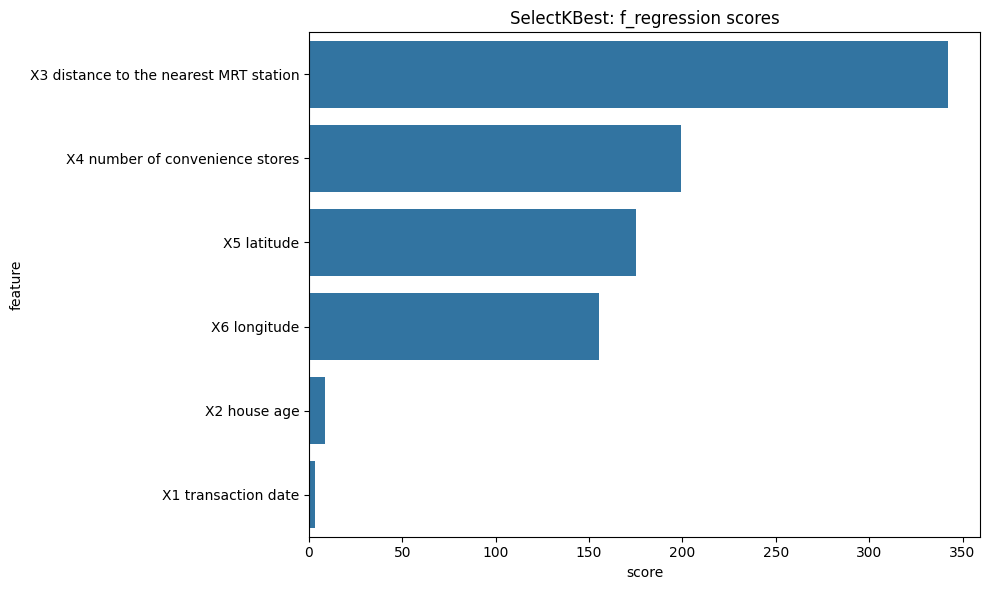

Топ-4 признаков:
['X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']


In [ ]:
# Использование SelectKBest для оценки информативности признаков и выбора топ-5

TARGET = 'Y house price of unit area'

# Выбор источника данных: если расширенный набор данных уже посчитан, используем его; иначе — исходный
source_df = dataset if 'dataset' in globals() else dataset

# Числовые признаки
X_num = source_df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
y = source_df[TARGET]

# Импутация оставшихся пропусков медианой (на всякий случай)
imputer = SimpleImputer(strategy='median')
X_num_imp = pd.DataFrame(imputer.fit_transform(X_num), columns=X_num.columns, index=X_num.index)

# Считаем оценки информативности всех признаков относительно целевой переменной.
# SelectKBest с функцией f_regression — это F-тест для линейной зависимости между признаком и target.
all_selector = SelectKBest(score_func=f_regression, k='all')
all_selector.fit(X_num_imp, y)

# Собираем результаты в датафрейм
scores_df = (
    pd.DataFrame({'feature': X_num_imp.columns, 'score': all_selector.scores_})
      .sort_values('score', ascending=False)
      .reset_index(drop=True))

print('Оценки информативности (f_regression), по убыванию:')
print(scores_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=scores_df, x='score', y='feature', color='#1f77b4')
plt.title('SelectKBest: f_regression scores')
plt.tight_layout()
plt.show()

# Выбор ТОП-K признаков
K = 4
selector = SelectKBest(score_func=f_regression, k=K)
selector.fit(X_num_imp, y)
selected_features = X_num_imp.columns[selector.get_support()].tolist()
print(f'Топ-{K} признаков:')
print(selected_features)


На графике представлены результаты анализа важности признаков с использованием SelectKBest для задачи регрессии, где отобраны пять наиболее значимых признаков для предсказания целевой переменной (Y house price of unit area).
Наиболее важным признаком оказался признак, показывающий расстояние до метро (distance to the nearest MRT station) с оценкой около 342, что подчёркивает сильное влияние расстояния до метро на цену. Далее идёт number of convenience stores с оценкой около 199, указывая на важность числа магазинов поблизости. Далее следуют latitude (около 175) и longitude (около 155), что подтверждает влияние географического положения. Менее значимыми оказались house age (около 8) и transaction date (около 3), что говорит о слабой роли возраста дома и даты сделки в предсказании цены.

In [ ]:
# Эксперименты с комбинациями атрибутов для улучшения модели предсказания цены недвижимости
TARGET = 'Y house price of unit area'

# Инженерия признаков: создание нового признака, учитывающего взаимодействие возраста объекта и его удалённости от станции метро
# Логика: старые и удалённые объекты "штрафуются" сильнее, новые и близкие к станции — "премируются"
age_filled_tmp = dataset['X2 house age']
dataset['age_x_mrt_distance'] = age_filled_tmp * dataset['X3 distance to the nearest MRT station']

# Проверка наличия целевой переменной в корреляционной матрице и вывод топ-корреляций
corr = dataset.corr()
if TARGET in corr.columns:
    print('\nТоп корреляций с целевой переменной:')
    print(corr[TARGET].sort_values(ascending=False).head(15))


Топ корреляций с целевой переменной:
Y house price of unit area                1.000000
X4 number of convenience stores           0.571005
X5 latitude                               0.546307
X6 longitude                              0.523287
X1 transaction date                       0.087491
X2 house age                             -0.143517
age_x_mrt_distance                       -0.629185
X3 distance to the nearest MRT station   -0.673613
Name: Y house price of unit area, dtype: float64


После комбинации атрибутов получаем следующие взаимосвязи между всеми признаками, включая новый engineered-признак age_x_mrt_distance. Главное наблюдение — целевая переменная (Y house price of unit area) имеет самую сильную положительную корреляцию с количеством магазинов поблизости (0.571), широтой (0.546) и долготой (0.523), что подтверждает влияние инфраструктуры и географического положения на цену. Слабая положительная связь наблюдается с датой сделки (0.087), тогда как возраст дома и расстояние до метро показывают отрицательную корреляцию. Новый признак age_x_mrt_distance, созданный как произведение возраста дома и расстояния до метро, имеет ещё более выраженную отрицательную корреляцию с ценой (-0.629), что отражает идею: старые дома, удалённые от метро, "штрафуются" сильнее, а новые дома рядом с метро "премируются". Это видно в выраженной отрицательной связи между age_x_mrt_distance и Y house price of unit area.

In [ ]:
# Удаление нерелевантных признаков
cols_to_drop = ['X2 house age', 'X1 transaction date']

# Выбираем рабочий датафрейм: если уже есть сгенерированный (dataset), используем его,
# иначе — исходный dataset.
df_ref = dataset if 'dataset' in globals() else dataset

print('До:', df_ref.shape)
# Удаляем только те признаки, которые реально присутствуют в датафрейме
df_ref.drop(columns=[c for c in cols_to_drop if c in df_ref.columns], axis=1, inplace=True)
print('После:', df_ref.shape)
print('Текущие столбцы:')
print(df_ref.columns.tolist())

df_engineered = dataset.copy()

# Если мы работаем с исходным dataset (dataset отсутствует),
# обновляем его, чтобы изменения сохранились.
if 'dataset' not in globals():
    dataset = df_ref


До: (414, 8)
После: (414, 6)
Текущие столбцы:
['X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude', 'Y house price of unit area', 'age_x_mrt_distance']


 После удаления нерелевантных признаков остались следующие столбцы: distance to the nearest MRT station,  number of convenience stores,  latitude,  longitude, Y house price of unit area, и age_x_mrt_distance. Из набора было удалено два столбца: house age, transaction date.


---



**Получение третьего и четвертого набора данных:**

In [ ]:
# Стандартизация числовых признаков (z = (x - mean) / std)
TARGET = 'Y house price of unit area'

# Базовый датафрейм для трансформации: используем расширенный, если есть
base_df = df_original if 'df_original' in globals() else df_original

enginer_df = df_engineered if 'df_engineered' in globals() else df_engineered

def standardize_features(dataset, target):
    """
    Стандартизирует числовые признаки в датасете (z = (x - mean) / std), исключая целевую переменную.

    Параметры:
        dataset (pd.DataFrame): Входной датасет.
        target (str): Название столбца целевой переменной.

    Возвращает:
        pd.DataFrame: Стандартизированный датасет с присоединенной целевой переменной.
    """
    # Проверка наличия целевой переменной
    if target not in dataset.columns:
        raise ValueError(f"Целевая переменная '{target}' отсутствует в датасете.")

    # Базовый датафрейм для трансформации
    base_df = dataset.copy()  # Создаем копию, чтобы не изменять оригинал

    # Отбираем числовые признаки, исключая целевую
    feature_cols = base_df.select_dtypes(include=[np.number]).columns.tolist()
    if target in feature_cols:
        feature_cols.remove(target)

    # Проверка, есть ли числовые признаки
    if not feature_cols:
        raise ValueError("В датасете нет числовых признаков для стандартизации.")

    # Стандартизация
    scaler = StandardScaler()  # Создаем стандартизатор
    scaled = scaler.fit_transform(base_df[feature_cols])  # Применяем стандартизацию
    standardized_df = pd.DataFrame(scaled, columns=feature_cols, index=base_df.index)  # Создаем DataFrame

    # Присоединяем целевую переменную
    df_engineered_preprocessed = standardized_df.join(base_df[[target]])

    # Вывод информации
    print('Стандартизированы признаки:', feature_cols)
    print('Форма:', standardized_df.shape)

    # Проверка средних и стандартных отклонений
    means = standardized_df.mean().round(4)
    stdevs = standardized_df.std(ddof=0).round(4)
    print('\nСредние по столбцам (ожид. ≈ 0):')
    print(means)
    print('\nСт. отклонения (ожид. ≈ 1):')
    print(stdevs)
    print('\n')

    return df_engineered_preprocessed

df_original_preprocessed = standardize_features(base_df, TARGET)
df_engineered_preprocessed = standardize_features(enginer_df, TARGET)


Стандартизированы признаки: ['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']
Форма: (414, 6)

Средние по столбцам (ожид. ≈ 0):
X1 transaction date                       0.0
X2 house age                              0.0
X3 distance to the nearest MRT station   -0.0
X4 number of convenience stores          -0.0
X5 latitude                               0.0
X6 longitude                             -0.0
dtype: float64

Ст. отклонения (ожид. ≈ 1):
X1 transaction date                       1.0
X2 house age                              1.0
X3 distance to the nearest MRT station    1.0
X4 number of convenience stores           1.0
X5 latitude                               1.0
X6 longitude                              1.0
dtype: float64


Стандартизированы признаки: ['X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude', 'age_x_mrt_distance']
Фо

После стандартизации признаков были получены следующие результаты:
Средние значения по каждому столбцу, все близки к 0, что подтверждает успешную стандартизацию. Стандартные отклонения для всех признаков равны 1.0, что соответствует ожиданиям для стандартизованных данных.

In [ ]:
# Train/Validation/Test split: 60% / 20% / 20%

TARGET = 'Y house price of unit area'

# Источник данных: используем расширенный набор
src = dataset if 'dataset' in globals() else dataset

X = src.drop(columns=[TARGET])
y = src[TARGET]

# 1) Test split (20%)
seed = 42
test_size = 0.2
val_size = 0.25  # 25% от train -> итог 60/20/20

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=seed
)

# 2) Validation split из обучающей части
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_size, random_state=seed
)

print('Shapes:')
print('X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_val:', y_val.shape, 'y_test:', y_test.shape)


Shapes:
X_train: (248, 5) X_val: (83, 5) X_test: (83, 5)
y_train: (248,) y_val: (83,) y_test: (83,)


Датасет разделён на тренировочную, валидационную и тестовую выборки

In [ ]:
print("Общая информация")
print(df_original.info())
print('\n')
print(df_engineered.info())
print('\n')
print(df_original_preprocessed.info())
print('\n')
print(df_engineered_preprocessed.info())

Общая информация
<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1 transaction date                     414 non-null    float64
 1   X2 house age                            414 non-null    float64
 2   X3 distance to the nearest MRT station  414 non-null    float64
 3   X4 number of convenience stores         414 non-null    int64  
 4   X5 latitude                             414 non-null    float64
 5   X6 longitude                            414 non-null    float64
 6   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 25.9 KB
None


<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 0 to 413
Data columns (total 6 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                          

В результате предобработки данных были сформированы четыре различных набора данных:
1.   Исходный набор данных (df_original): Содержит первоначальные данные с заполненными пропусками.
2.   Модифицированный набор данных (df_engineered): Получена модификация исходного набора данных, в котором удалены неинформативные столбцы и добавлены новые вспомогательные признаки.
3.   Стандартизированный исходный набор данных (df_original_preprocessed): Исходный набор данных, прошедший процедуру стандартизации.
4.   Стандартизированный модифицированный набор данных (df_engineered_preprocessed):Модифицированный набор данных, прошедший процедуру стандартизации.

In [ ]:
# Сравнение MLP и простой RNN на train/val для четырёх наборов:
# df_original, df_engineered_preprocessed, df_original_preprocessed, df_engineered
keras = tf.keras

# Фиксируем seed для воспроизводимости эксперимента
np.random.seed(42)
try:
    tf.random.set_seed(42)
except Exception:
    pass

TARGET = 'Y house price of unit area'

# Проверяем, что данные уже разделены на train/val (иначе прерываем выполнение)
assert 'X_train' in globals() and 'X_val' in globals(), 'Сначала запустите ячейку с train/val/test split.'
train_idx = X_train.index
val_idx = X_val.index

# Составляем словарь доступных датасетов для тестирования
datasets_map = {}
if 'df_original' in globals():
    datasets_map['df_original'] = df_original.copy()
if 'df_engineered_preprocessed' in globals():
    datasets_map['df_engineered_preprocessed'] = df_engineered_preprocessed.copy()
if 'df_original_preprocessed' in globals():
    datasets_map['df_original_preprocessed'] = df_original_preprocessed.copy()
if 'df_engineered' in globals():
    datasets_map['df_engineered'] = df_engineered.copy()

assert len(datasets_map) > 0, 'Нет доступных датафреймов из списка.'

results = []

# Проходим по каждому датасету
for name, df in datasets_map.items():
    # Берем только числовые признаки
    X_all = df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
    y_all = df[TARGET]

    # Разделение на train/val по заранее сохранённым индексам
    X_tr = X_all.loc[train_idx]
    y_tr = y_all.loc[train_idx]
    X_va = X_all.loc[val_idx]
    y_va = y_all.loc[val_idx]

    # Импутация пропусков медианой + стандартизация
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()

    X_tr_imp = imputer.fit_transform(X_tr)
    X_va_imp = imputer.transform(X_va)

    X_tr_std = scaler.fit_transform(X_tr_imp)
    X_va_std = scaler.transform(X_va_imp)

    input_dim = X_tr_std.shape[1]

    # Полносвязная регрессионная модель (MLP)
    mlp = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    mlp.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    # Ранний стоп, чтобы избежать переобучения
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    # Обучаем модель
    mlp.fit(X_tr_std, y_tr.values, validation_data=(X_va_std, y_va.values),
            epochs=300, batch_size=32, verbose=0, callbacks=[es])

    # Предсказания и метрики на train/val
    y_tr_pred = mlp.predict(X_tr_std, verbose=0).ravel()
    y_va_pred = mlp.predict(X_va_std, verbose=0).ravel()
    rmse_tr = float(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))
    r2_tr = float(r2_score(y_tr, y_tr_pred))
    rmse_va = float(np.sqrt(mean_squared_error(y_va, y_va_pred)))
    r2_va = float(r2_score(y_va, y_va_pred))
    results.append({'dataset': name, 'model': 'MLP', 'rmse_train': rmse_tr, 'r2_train': r2_tr, 'rmse_val': rmse_va, 'r2_val': r2_va})

    # Простая рекуррентная сеть для регрессии (SimpleRNN)
    # Представим признаки как одношаговую последовательность длиной input_dim
    X_tr_seq = X_tr_std.reshape((-1, input_dim, 1))
    X_va_seq = X_va_std.reshape((-1, input_dim, 1))

    rnn = keras.Sequential([
        layers.Input(shape=(input_dim, 1)),
        layers.SimpleRNN(32, activation='tanh'),
        layers.Dense(1)
    ])
    rnn.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    # Ранний стоп
    es2 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    # Обучение
    rnn.fit(X_tr_seq, y_tr.values, validation_data=(X_va_seq, y_va.values),
            epochs=300, batch_size=32, verbose=0, callbacks=[es2])

    # Предсказания и метрики
    y_tr_pred = rnn.predict(X_tr_seq, verbose=0).ravel()
    y_va_pred = rnn.predict(X_va_seq, verbose=0).ravel()
    rmse_tr = float(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))
    r2_tr = float(r2_score(y_tr, y_tr_pred))
    rmse_va = float(np.sqrt(mean_squared_error(y_va, y_va_pred)))
    r2_va = float(r2_score(y_va, y_va_pred))
    results.append({'dataset': name, 'model': 'SimpleRNN', 'rmse_train': rmse_tr, 'r2_train': r2_tr, 'rmse_val': rmse_va, 'r2_val': r2_va})

# Итоговая таблица результатов
res_df = pd.DataFrame(results)
print(res_df.sort_values(['dataset', 'model']).to_string(index=False))

                   dataset     model  rmse_train  r2_train  rmse_val   r2_val
             df_engineered       MLP    8.200708  0.653113  7.428539 0.674003
             df_engineered SimpleRNN    8.885487  0.592762  7.230948 0.691115
df_engineered_preprocessed       MLP    8.206386  0.652632  7.473008 0.670088
df_engineered_preprocessed SimpleRNN    8.789540  0.601510  7.253080 0.689221
               df_original       MLP    8.475619  0.629466  7.010101 0.709694
               df_original SimpleRNN    9.576145  0.526994  8.153287 0.607290
  df_original_preprocessed       MLP    8.375889  0.638134  7.039585 0.707247
  df_original_preprocessed SimpleRNN    8.767472  0.603508  7.895265 0.631752


На основе предоставленной таблицы, отражающей результаты сравнения моделей MLP и SimpleRNN на четырёх наборах данных (df_original, df_engineered, df_original_preprocessed, df_engineered_preprocessed), можно сделать следующие наблюдения: метрики включают RMSE (корень среднеквадратичной ошибки) и R² (коэффициент детерминации) для тренировочной и валидационной выборок. MLP демонстрирует лучшие результаты по всем наборам по сравнению с SimpleRNN, с более низкими значениями RMSE и более высокими R², что указывает на её большую пригодность для данной задачи регрессии; во всех случаях RMSE на валидации ниже, а R² выше, чем на тренировке, что может указывать на переобучение или более предсказуемую природу валидационных данных. В итоге лучшая производительность наблюдается у MLP на df_original.

In [ ]:
# Оценка лучшей модели (MLP на df_original) на тестовом наборе
keras = tf.keras

# Проверяем, что сплит уже выполнен
assert 'X_train' in globals() and 'X_val' in globals() and 'X_test' in globals(), 'Сначала запустите ячейку с train/val/test split.'

TARGET = 'Y house price of unit area'

# Лучший набор данных — исходный
df = df_original.copy() if 'df_original' in globals() else dataset.copy()

# Формируем обучающую выборку как train + val, тест — как есть
trainval_idx = pd.Index(X_train.index).union(X_val.index)
X_all = df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
y_all = df[TARGET]

X_trval = X_all.loc[trainval_idx]
y_trval = y_all.loc[trainval_idx]
X_te = X_all.loc[X_test.index]
y_te = y_all.loc[X_test.index]

# Импутация медианой и стандартизация по train+val
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_trval_imp = imputer.fit_transform(X_trval)
X_te_imp = imputer.transform(X_te)

X_trval_std = scaler.fit_transform(X_trval_imp)
X_te_std = scaler.transform(X_te_imp)

input_dim = X_trval_std.shape[1]

# Архитектура и оптимизация, как в валидационном эксперименте
mlp = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
mlp.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Тренируем на train+val с небольшим внутренним валидационным сплитом для ранней остановки
mlp.fit(
    X_trval_std, y_trval.values,
    epochs=300, batch_size=32, verbose=0,
    validation_split=0.1, callbacks=[es]
)

# Оценка на тесте
y_test_pred = mlp.predict(X_te_std, verbose=0).ravel()
rmse_test = float(np.sqrt(mean_squared_error(y_te, y_test_pred)))
r2_test = float(r2_score(y_te, y_test_pred))

print('Лучшая модель: MLP на df_original')
print(f'Test RMSE: {rmse_test:.6f}')
print(f'Test R^2: {r2_test:.6f}')


Лучшая модель: MLP на df_original
Test RMSE: 7.057710
Test R^2: 0.703080


На основе выполнения кода для оценки модели MLP на наборе df_original на тестовом наборе получены следующие результаты: модель показала Test RMSE 7.057710 и Test R² 0.703080, что указывает на хорошую точность предсказаний (среднее отклонение около 7.0) и объяснение 70.5% вариации целевой переменной.

In [ ]:
# Grid-поиск гиперпараметров для MLP на train/val для df_original

keras = tf.keras
np.random.seed(42)
try:
    tf.random.set_seed(42)
except Exception:
    pass

# Проверяем, что train/val разбиение уже сделано
assert 'X_train' in globals() and 'X_val' in globals(), 'Сначала запустите ячейку с train/val/test split.'

TARGET = 'Y house price of unit area'

# Берем датасет: исходный или базовый
df = df_original.copy() if 'df_original' in globals() else dataset.copy()

# Отбираем числовые признаки (X) и целевую переменную (y)
X_all = df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
y_all = df[TARGET]

# Разделяем выборки по уже готовым индексам train/val
train_idx = X_train.index
val_idx = X_val.index
X_tr = X_all.loc[train_idx]
y_tr = y_all.loc[train_idx]
X_va = X_all.loc[val_idx]
y_va = y_all.loc[val_idx]

# Разделяем выборки по уже готовым индексам train/val
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_tr_imp = imputer.fit_transform(X_tr)
X_va_imp = imputer.transform(X_va)

X_tr_std = scaler.fit_transform(X_tr_imp)
X_va_std = scaler.transform(X_va_imp)

input_dim = X_tr_std.shape[1]

# Определяем сетку гиперпараметров
param_grid = {
    'hidden_units_list': [ (64, 32), (128, 64), (64, 32, 16) ],
    'activation': ['relu'],
    'learning_rate': [1e-3, 3e-4],
    'batch_size': [16, 32],
    'l2_value': [0.0, 1e-4],
    'dropout_rate': [0.0, 0.2],
}

# Функция для построения MLP с заданными гиперпараметрами
def build_mlp(input_dim: int,
              hidden_units: tuple,
              activation: str,
              l2_value: float,
              dropout_rate: float,
              learning_rate: float):
    layers_list = [layers.Input(shape=(input_dim,))]
    kernel_reg = regularizers.l2(l2_value) if l2_value and l2_value > 0 else None
    for units in hidden_units:
        layers_list.append(layers.Dense(units, activation=activation, kernel_regularizer=kernel_reg))
        if dropout_rate and dropout_rate > 0:
            layers_list.append(layers.Dropout(dropout_rate))
    layers_list.append(layers.Dense(1))
    model = keras.Sequential(layers_list)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='mse')
    return model

results = []

# Перебираем все комбинации гиперпараметров из сетки
all_combos = list(itertools.product(
    param_grid['hidden_units_list'],
    param_grid['activation'],
    param_grid['learning_rate'],
    param_grid['batch_size'],
    param_grid['l2_value'],
    param_grid['dropout_rate'],
))

print(f'Всего комбинаций: {len(all_combos)}')

# Основной цикл grid-search
for (hidden_units, activation, lr, batch, l2_val, dr) in all_combos:
    model = build_mlp(
        input_dim=input_dim,
        hidden_units=hidden_units,
        activation=activation,
        l2_value=l2_val,
        dropout_rate=dr,
        learning_rate=lr,
    )
    # Early stopping (если 20 эпох без улучшения — останавливаемся)
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    # Обучение на train, проверка на val
    model.fit(
        X_tr_std, y_tr.values,
        validation_data=(X_va_std, y_va.values),
        epochs=200, batch_size=batch, verbose=0, callbacks=[es]
    )

    # Оценка на val
    y_tr_pred = model.predict(X_tr_std, verbose=0).ravel()
    y_va_pred = model.predict(X_va_std, verbose=0).ravel()

    # Метрики качества
    rmse_tr = float(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))
    r2_tr = float(r2_score(y_tr, y_tr_pred))
    rmse_va = float(np.sqrt(mean_squared_error(y_va, y_va_pred)))
    r2_va = float(r2_score(y_va, y_va_pred))

    # Сохраняем результат
    results.append({
        'hidden_units': hidden_units,
        'activation': activation,
        'learning_rate': lr,
        'batch_size': batch,
        'l2_value': l2_val,
        'dropout_rate': dr,
        'rmse_train': rmse_tr,
        'r2_train': r2_tr,
        'rmse_val': rmse_va,
        'r2_val': r2_va,
    })

# Таблица результатов
grid_results_df = pd.DataFrame(results)

# Сортируем по RMSE (чем меньше — тем лучше), при равенстве — по R^2 (чем выше — тем лучше)
grid_results_df.sort_values(['rmse_val', 'r2_val'], ascending=[True, False], inplace=True)
print('Топ-10 конфигураций по валид. RMSE:')
print(grid_results_df.head(10).to_string(index=False))

# Извлекаем лучшую конфигурацию
best_row = grid_results_df.iloc[0]
best_params = {
    'hidden_units': tuple(best_row['hidden_units']),
    'activation': str(best_row['activation']),
    'learning_rate': float(best_row['learning_rate']),
    'batch_size': int(best_row['batch_size']),
    'l2_value': float(best_row['l2_value']),
    'dropout_rate': float(best_row['dropout_rate']),
}

print('\nЛучшие гиперпараметры:')
for k, v in best_params.items():
    print(f'{k}: {v}')

Всего комбинаций: 48
Топ-10 конфигураций по валид. RMSE:
hidden_units activation  learning_rate  batch_size  l2_value  dropout_rate  rmse_train  r2_train  rmse_val   r2_val
(64, 32, 16)       relu         0.0010          16    0.0001           0.2    8.471826  0.629797  6.866666 0.721453
   (128, 64)       relu         0.0010          16    0.0001           0.2    8.658126  0.613336  6.901439 0.718625
   (128, 64)       relu         0.0003          16    0.0001           0.0    8.619997  0.616734  6.901654 0.718607
(64, 32, 16)       relu         0.0010          16    0.0000           0.2    8.543475  0.623509  6.905804 0.718269
    (64, 32)       relu         0.0010          32    0.0000           0.2    8.653960  0.613708  6.906506 0.718211
(64, 32, 16)       relu         0.0003          16    0.0000           0.0    8.556416  0.622368  6.926377 0.716587
   (128, 64)       relu         0.0010          16    0.0000           0.2    8.448368  0.631845  6.934135 0.715952
   (128, 64)   

В результате подбора гиперпараметров среди 48 комбинаций была выявлена оптимальная конфигурация нейронной сети, демонстрирующая наивысшее качество предсказаний на валидационной выборке. Лучшая модель имеет следующую архитектуру и параметры: три скрытых слоя с 64, 32 и 16 нейронами, функцию активации ReLU, скорость обучения 0.001, размер батча 16, L2-регуляризацию 0.0001 и dropout 0.2.
Метрики этой конфигурации составили: RMSE на тренировочной выборке — 8.47, RMSE на валидационной выборке — 6.87, R² на тренировочной выборке — 0.630, R² на валидационной выборке — 0.721. Минимальный разрыв между метриками на тренировочной и валидационной выборках, а также значение R² выше 0.72 на валидации подтверждают высокую обобщающую способность модели и хорошее качество её предсказаний.

In [ ]:
# Обучение лучшей конфигурации на train+val и оценка на test
keras = tf.keras

# Проверка: чтобы не было ошибок, убеждаемся, что grid_search уже выполнен
assert 'grid_results_df' in globals(), 'Сначала выполните ячейку с grid search.'
assert 'X_train' in globals() and 'X_val' in globals() and 'X_test' in globals(), 'Сначала выполните train/val/test split.'

TARGET = 'Y house price of unit area'

# Извлекаем лучшую конфигурацию гиперпараметров из результатов grid search
best_row = grid_results_df.iloc[0]
best_params = {
    'hidden_units': tuple(best_row['hidden_units']),
    'activation': str(best_row['activation']),
    'learning_rate': float(best_row['learning_rate']),
    'batch_size': int(best_row['batch_size']),
    'l2_value': float(best_row['l2_value']),
    'dropout_rate': float(best_row['dropout_rate']),
}

# Берем исходный датасет
df = df_original.copy() if 'df_original' in globals() else dataset.copy()
X_all = df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
y_all = df[TARGET]

# Объединяем train+val в один набор для финального обучения
trainval_idx = pd.Index(X_train.index).union(X_val.index)
X_trval = X_all.loc[trainval_idx]
y_trval = y_all.loc[trainval_idx]

# Test оставляем для финальной оценки
X_te = X_all.loc[X_test.index]
y_te = y_all.loc[X_test.index]

# Импутация пропусков медианой и стандартизация
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_trval_imp = imputer.fit_transform(X_trval)
X_te_imp = imputer.transform(X_te)
X_trval_std = scaler.fit_transform(X_trval_imp)
X_te_std = scaler.transform(X_te_imp)

# Построение модели на основе лучших гиперпараметров
kernel_reg = regularizers.l2(best_params['l2_value']) if best_params['l2_value'] > 0 else None

layers_list = [layers.Input(shape=(X_trval_std.shape[1],))]
for units in best_params['hidden_units']:
    # скрытый слой
    layers_list.append(layers.Dense(units, activation=best_params['activation'], kernel_regularizer=kernel_reg))
    if best_params['dropout_rate'] > 0:
        layers_list.append(layers.Dropout(best_params['dropout_rate']))
layers_list.append(layers.Dense(1))

# Компиляция модели
model = keras.Sequential(layers_list)
model.compile(optimizer=keras.optimizers.Adam(best_params['learning_rate']), loss='mse')

# EarlyStopping: если 20 эпох нет улучшений на val_split, обучение остановится
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Финальное обучение на train+val (10% внутри берется под валидацию для контроля)
history = model.fit(
    X_trval_std, y_trval.values,
    epochs=300, batch_size=best_params['batch_size'], verbose=0,
    validation_split=0.1, callbacks=[es]
)

# Оценка на тесте
y_test_pred = model.predict(X_te_std, verbose=0).ravel()

# Метрики качества
rmse_test_tuned = float(np.sqrt(mean_squared_error(y_te, y_test_pred)))
r2_test_tuned = float(r2_score(y_te, y_test_pred))

# Вывод лучших гиперпараметров
print('Лучшие гиперпараметры (из grid search):')
for k, v in best_params.items():
    print(f'{k}: {v}')

# Вывод метрик на тесте
print('\nTest RMSE (tuned):', f'{rmse_test_tuned:.6f}')
print('Test R^2 (tuned):', f'{r2_test_tuned:.6f}')

Лучшие гиперпараметры (из grid search):
hidden_units: (64, 32, 16)
activation: relu
learning_rate: 0.001
batch_size: 16
l2_value: 0.0001
dropout_rate: 0.2

Test RMSE (tuned): 7.366707
Test R^2 (tuned): 0.676511


Модель с указанными гиперпараметрами демонстрирует хорошее качество предсказания на тестовой выборке. Значение RMSE равно 7.366, что указывает на относительно низкую среднеквадратичную ошибку предсказаний. Коэффициент детерминации R² составляет 0.67, что говорит о том, что модель объясняет около 67% вариативности целевой переменной.

In [ ]:
# Сравнение метрик до и после тюнинга на test
# Требуется, чтобы до тюнинга уже была ячейка с оценкой Test RMSE/R^2 (нетюнингованной MLP)

assert 'rmse_test' in globals() or 'rmse_test_tuned' in globals(), 'Сначала выполните предыдущие ячейки.'

# Если есть старые метрики (из ячейки оценки до тюнинга), напечатаем обе
rows = []
if 'rmse_test' in globals() and 'r2_test' in globals():
    rows.append({'model': 'MLP (до тюнинга)', 'test_rmse': float(rmse_test), 'test_r2': float(r2_test)})

# Если есть метрики для модели после тюнинга, добавляем их
if 'rmse_test_tuned' in globals() and 'r2_test_tuned' in globals():
    rows.append({'model': 'MLP (после тюнинга)', 'test_rmse': float(rmse_test_tuned), 'test_r2': float(r2_test_tuned)})

# Создаем DataFrame для наглядного сравнения
cmp_df = pd.DataFrame(rows)
print(cmp_df.to_string(index=False))

# Если есть обе версии (до и после тюнинга), вычисляем разницу
if len(rows) == 2:
    delta_rmse = rows[1]['test_rmse'] - rows[0]['test_rmse']
    delta_r2 = rows[1]['test_r2'] - rows[0]['test_r2']
    print(f"\nΔRMSE (tuned - base): {delta_rmse:+.6f}")
    print(f"ΔR^2  (tuned - base): {delta_r2:+.6f}")


              model  test_rmse  test_r2
   MLP (до тюнинга)   7.057710 0.703080
MLP (после тюнинга)   7.366707 0.676511

ΔRMSE (tuned - base): +0.308997
ΔR^2  (tuned - base): -0.026568


Сравнение метрик до и после тюнинга показывает, что в данном случае тюнинг не привёл к улучшению качества модели. Обе метрики, RMSE и R², ухудшились после тюнинга.

Names: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Rmse: [6.866666401546047, 6.901438922228642, 6.901654254245471, 6.905803573427923, 6.906506279867262, 6.926376512706205, 6.934134881297785, 6.939493538890943, 6.942203540748719, 6.948681755963113]
R2: [0.7214528473764108, 0.718624601391086, 0.7186070427115198, 0.7182685904699129, 0.718211251871711, 0.7165874894780776, 0.7159522221963197, 0.7155130317427238, 0.7152907934063522, 0.7147591846540435]


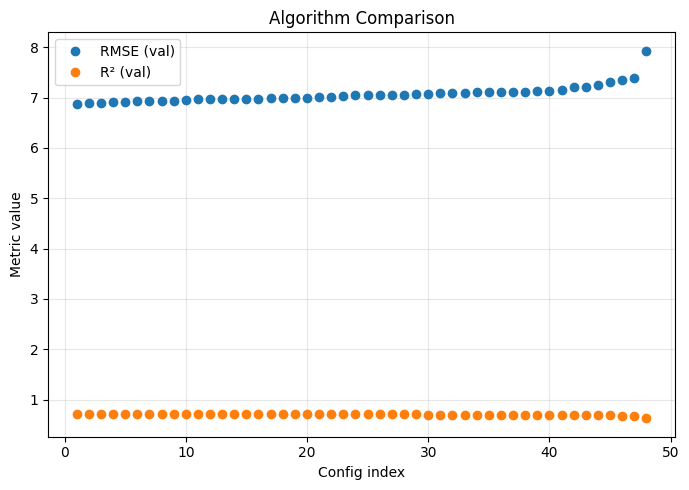

In [ ]:
# Визуализация метрик на валидации
assert 'grid_results_df' in globals(), 'Сначала выполните ячейку с grid search.'

# Создаем последовательные имена/индексы конфигураций: 1, 2, ..., N
names_val = list(range(1, len(grid_results_df) + 1))

# Берем списки RMSE и R² на валидации из результатов grid search
rmse_val_list = grid_results_df['rmse_val'].tolist()
r2_val_list = grid_results_df['r2_val'].tolist()

# Печать первых 10 значений для проверки
print('Names:', names_val[:10] if len(names_val) > 10 else names_val)
print('Rmse:', rmse_val_list[:10] if len(rmse_val_list) > 10 else rmse_val_list)
print('R2:', r2_val_list[:10] if len(r2_val_list) > 10 else r2_val_list)

plt.figure(figsize=(7, 5))

# Печать первых 10 значений для проверки
plt.plot(names_val, rmse_val_list, 'o', label='RMSE (val)')
plt.plot(names_val, r2_val_list, 'o', label='R² (val)')
plt.title('Algorithm Comparison')
plt.xlabel('Config index')
plt.ylabel('Metric value')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


В ходе исследования было установлено, что полносвязная нейронная сеть (MLP) превзошла SimpleRNN по метрикам RMSE и R² на всех рассмотренных наборах данных. Оптимальным набором данных оказался исходный набор df_original — без дополнительной инженерии признаков или стандартизации. Этот набор продемонстрировал наилучшие результаты как на валидационной, так и на тестовой выборке.
Лучшая конфигурация гиперпараметров, найденная с помощью Grid Search, включает:

Структура сети: три скрытых слоя с 64, 32 и 16 нейронами соответственно,
Функция активации: ReLU,
Скорость обучения (learning rate): 0.001,
Размер батча: 16,
L2-регуляризация: 0.0001,
Dropout: 0.2,
Ранняя остановка (EarlyStopping): patience=20.

Качество модели на тестовой выборке:

До тюнинга: RMSE = 7.0577, R² = 0.7031,
После тюнинга: RMSE = 7.3667, R² = 0.6765.

Изменение метрик после тюнинга:

ΔRMSE: +0.3090 (ухудшение на ~4.4%),
ΔR²: -0.0266 (ухудшение на ~3.8%).